In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from pathlib import Path
import struct
import json
import seaborn as sns

In [2]:
df=pd.read_csv("../../../data/lastPointCloud.csv")

In [3]:
print(df.head())

          x         y         z   r   g   b
0  3.502989  1.214654 -1.431428  35  37  34
1  3.551421  1.191114 -1.432799  37  41  36
2  3.663276  1.207017 -1.418487  34  34  32
3  3.754585  1.193994 -1.413791  41  40  39
4  3.850423  1.212784 -1.418521  36  36  33


In [4]:
# factor=10
factor=10

In [5]:
df_10_rows=df.iloc[::factor,:]

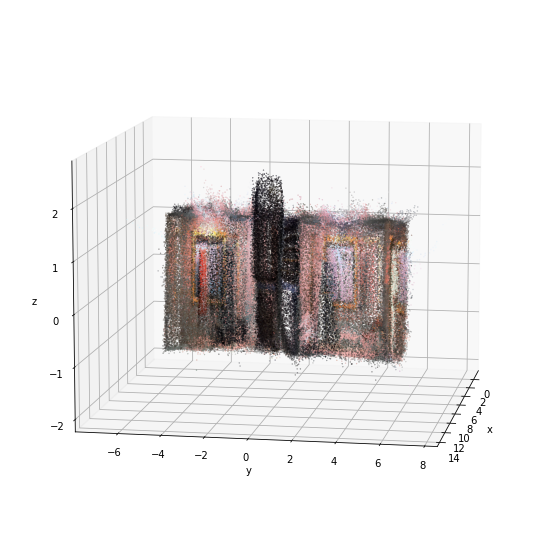

In [6]:
# %matplotlib qt
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection="3d")
ax.scatter(df_10_rows["x"],df_10_rows["y"],df_10_rows["z"],c=df_10_rows[["r","g","b"]]/255,s=0.1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ele=10
azm=10
ax.view_init(elev=ele, azim=azm)

In [7]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [19]:
pcd=o3d.geometry.PointCloud()
pcd.points=o3d.utility.Vector3dVector(df[["x","y","z"]].to_numpy())
pcd.colors=o3d.utility.Vector3dVector(df[["r","g","b"]].to_numpy()/255)

In [23]:
o3d.visualization.draw_geometries([pcd])

In [9]:
pcd.estimate_normals() # estimate normal vectors, used in ball_pivoting reconstruction

In [10]:
o3d.visualization.draw_geometries([pcd], point_show_normal=False)

## Clustering

In [12]:
with o3d.utility.VerbosityContextManager( o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array( pcd.cluster_dbscan(eps=0.05, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
cluster_pcd=pcd
cluster_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([cluster_pcd],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2070
point cloud has 2070 clusters


In [15]:
from collections import Counter

In [21]:
label_counter=Counter(labels)
most_common_label=label_counter.most_common(1)[0][0]
print(label_counter.most_common(1))
most_common_pcd=pcd.select_by_index(np.where(labels==most_common_label)[0])
o3d.visualization.draw_geometries([most_common_pcd])

[(0, 1899460)]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


## [remove outliers](http://www.open3d.org/docs/0.12.0/tutorial/geometry/pointcloud_outlier_removal.html#:~:text=0.0694%2C%20%2D0.9768%2C%200.2024%5D-,Statistical%20outlier%20removal,-statistical_outlier_removal%20removes%20points)

In [9]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [10]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20,std_ratio=2.0)
display_inlier_outlier(pcd, ind)

Showing outliers (red) and inliers (gray): 


In [14]:
print(type(pcd))
print(type(cl))

<class 'open3d.cpu.pybind.geometry.PointCloud'>
<class 'open3d.cpu.pybind.geometry.PointCloud'>


In [11]:
inlier_cloud = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([inlier_cloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


# Bilateral Filter

## Surface reconstruction

In [16]:
distances=inlier_cloud.compute_nearest_neighbor_distance()
avd_dist=np.mean(distances)
radius=2*avd_dist

In [17]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(inlier_cloud,o3d.utility.DoubleVector([radius, radius * 2]))

In [18]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

In [19]:
output_path=Path("./Result")
if not output_path.exists():
    output_path.mkdir(parents=True)
o3d.io.write_triangle_mesh(str(output_path/"bpa_mesh.ply"),dec_mesh)
# o3d.io.write_triangle_mesh(output_path/"bpa_mesh.ply",dec_mesh)

True

In [20]:
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [21]:
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply", str(output_path))

generation of 100 LoD successful


In [24]:
# o3d.visualization.draw_geometries([my_lods[100000]])
o3d.visualization.draw_geometries([bpa_mesh])

## possion surface reconstruction

In [23]:
print("Remove outliers")
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=50,std_ratio=0.001)
cloud_remove_outliers = pcd.select_by_index(ind)
cloud_remove_outliers.estimate_normals()
o3d.visualization.draw_geometries([inlier_cloud])

Remove outliers
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [ ]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(cloud_remove_outliers, depth=8)
print(mesh)
o3d.visualization.draw_geometries([mesh], zoom=0.664, front=[-0.4761, -0.4698, -0.7434], lookat=[1.8900, 3.2596, 0.9284], up=[0.2304, -0.8825, 0.4101])

In [24]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


## Plane segmentation

In [29]:

plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

o3d.visualization.draw_geometries([inlier_cloud,outlier_cloud])
# o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                #   zoom=0.8,
                                #   front=[-0.4999, -0.1659, -0.8499],
                                #   lookat=[2.1813, 2.0619, 2.0999],
                                #   up=[0.1204, -0.9852, 0.1215])

Plane equation: -0.07x + 0.02y + 1.00z + 1.65 = 0
